In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.special import spherical_yn, spherical_jn

In [27]:
# styling for plots
sns.set(style="whitegrid", palette="muted")

mpl.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})

In [28]:
m1 = 939.565 #MeV/c^2
m2 = 3727.379 #MeV/c^2
hbar = 197 #MeV

mu = m1*m2/(m1+m2)

V0 = 50
a_sw = 5 #fm
a_ws = 0.5 #fm
R_ws = 5 #fm
R = 20 #matching radius for ws

h = 0.001 #step size
p = 1 #initial condition for derivative

In [29]:
def woods_saxon_potential(r, a):
    return -V0 / (1 + np.exp((r - R_ws) / a))

def square_well_potential(r):
    return np.where(r <= a_sw, -V0, 0)
    # return -V0 if r <= a_sw else 0

/var/folders/tm/9lkgb9zx49q21mqz50bclnhc0000gn/T/ipykernel_28398/1765485831.py:2: RuntimeWarning: overflow encountered in exp
  return -V0 / (1 + np.exp((r - R_ws) / a))


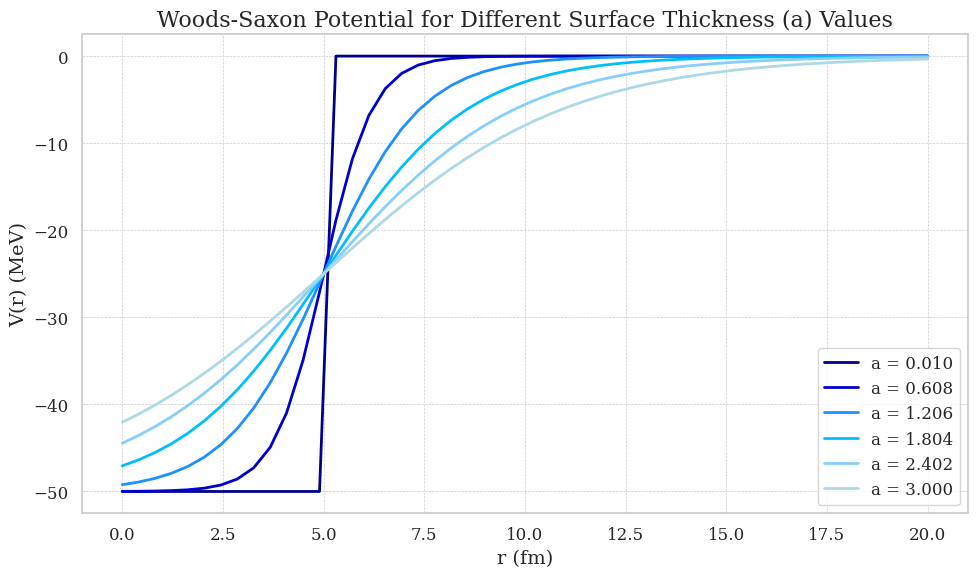

In [33]:
a_values = np.linspace(0.01, 3, 6)

plt.figure(figsize=(10, 6))

shades = ['#00008B', '#0000CD', '#1E90FF', '#00BFFF', '#87CEFA', '#ADD8E6']

# Plot the Woods-Saxon potential for each value of `a`
for a, shade in zip(a_values, shades):
    plt.plot(np.linspace(0, 20), woods_saxon_potential(np.linspace(0, 20), a), label=f"a = {a:.3f}", color=shade, linewidth=2)

plt.xlabel("r (fm)", fontsize=14)
plt.ylabel("V(r) (MeV)", fontsize=14)
plt.title("Woods-Saxon Potential for Different Surface Thickness (a) Values", fontsize=16)

plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

plt.tight_layout()
plt.show()


Compare Square Well Potential to Woods-Saxon for different values of a ("surface thickness")

/var/folders/tm/9lkgb9zx49q21mqz50bclnhc0000gn/T/ipykernel_28398/1765485831.py:2: RuntimeWarning: overflow encountered in exp
  return -V0 / (1 + np.exp((r - R_ws) / a))


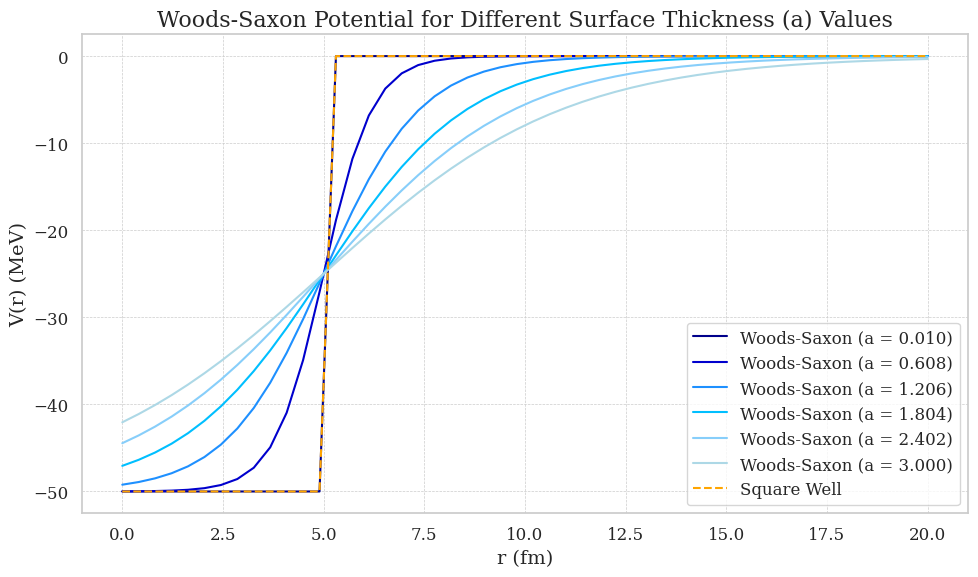

In [35]:
a_values = np.linspace(0.01, 3, 6) 

plt.figure(figsize=(10, 6)) 
shades = ['#00008B', '#0000CD', '#1E90FF', '#00BFFF', '#87CEFA', '#ADD8E6']

for a, shade in zip(a_values, shades):
    plt.plot(np.linspace(0, 20), woods_saxon_potential(np.linspace(0, 20), a), label=f"Woods-Saxon (a = {a:.3f})", color=shade)

plt.plot(np.linspace(0, 20), square_well_potential(np.linspace(0, 20)), label='Square Well', color='orange', linestyle='--', zorder=5)
plt.xlabel("r (fm)")
plt.ylabel("V(r) (MeV)")
plt.title("Woods-Saxon Potential for Different Surface Thickness (a) Values")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.legend()
plt.show()

--> Woods-Saxon potential approaching Square Well as a ("surface thickness") approaches 0

In [36]:
def F(l, r, E, potential, a):
    if potential == 'ws':
        return (2*mu/(hbar**2)*(woods_saxon_potential(r, a)-E) + (l*(l+1)/(r**2)))
    elif potential == 'sw':
        return (2*mu/(hbar**2)*(square_well_potential(r)-E) + (l*(l+1)/(r**2)))

def y_l(R, l, E, potential, a): # matching radius, angular momentum, energy, potential type
    r_values = np.arange(0, R + 2*h, h) # need one step beyond well
    N = len(r_values)

    y = np.zeros(N)
    z = np.zeros(N+1)

    z[0] = 0.0
    z[1] = p * h

    for i in range(1, N):
        r_cur = r_values[i]
        F_val = F(l, r_cur, E, potential, a)
        # print(F_val)
        z[i+1] = (2*z[i] - z[i-1] + (h**2 * F_val * z[i]))
        y[i] = ((1-(h**2/12*F_val))*z[i]) / r_cur
    
    return y

def y_prime(y):
    r2_index = len(y)-1
    r1_index = r2_index-2
    return ((y[r2_index]-y[r1_index])/(2*h))


In [37]:

def numerov_phase_shift(k, l, E, R, potential, a):
    kR = k * R

    y_array = y_l(R, l, E, potential, a)
    y_val = y_array[len(y_array)-2]
    y_prime_val = y_prime(y_array)
    
    numerator = y_prime_val * spherical_jn(l, kR) - k * y_val * spherical_jn(l, kR, True)
    denominator = k * y_val * (-1) * spherical_yn(l, kR, True) - y_prime_val * (-1) * spherical_yn(l, kR)

    delta_l = np.arctan2(numerator, denominator)
    return delta_l


def calculate_total_cross_sections_numerov(E_values, l_max, R, potential, a):
    cross_sections = []
    for E in E_values:
        k = np.sqrt((2 * mu * E) / hbar**2)
        total_cross_section = 0.
        for l in range(l_max + 1):
            delta_l = numerov_phase_shift(k, l, E, R, potential, a)
            total_cross_section += (2 * l + 1) * (np.sin(delta_l)) ** 2
        cross_sections.append((4 * np.pi / (k ** 2)) * total_cross_section)
    return cross_sections
            

Plot total cross sections up to l=0

/var/folders/tm/9lkgb9zx49q21mqz50bclnhc0000gn/T/ipykernel_28398/1765485831.py:2: RuntimeWarning: overflow encountered in exp
  return -V0 / (1 + np.exp((r - R_ws) / a))


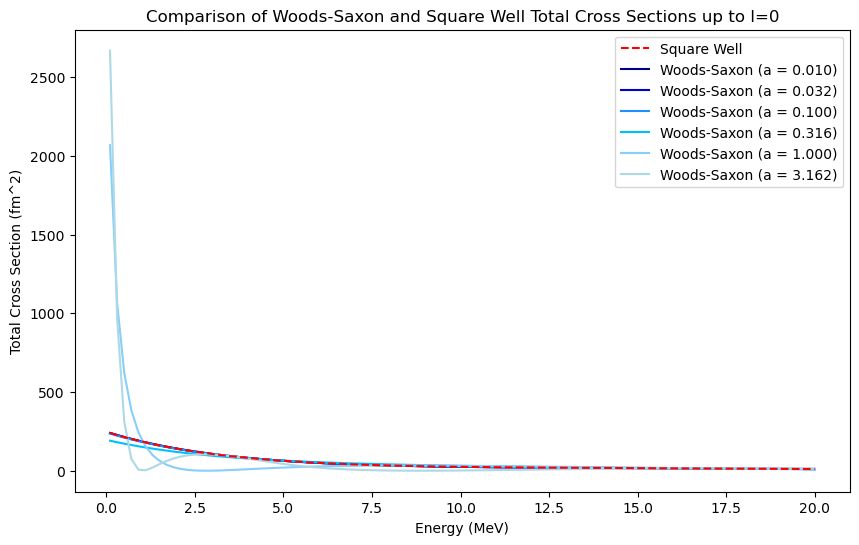

In [24]:
E_values = np.linspace(0.1, 20.0, 100)
a_values = np.logspace(-2, 0.5, 6)  # a approaching 0 logarithmically
l_max = 0

plt.figure(figsize=(10, 6)) 
shades = ['#00008B', '#0000CD', '#1E90FF', '#00BFFF', '#87CEFA', '#ADD8E6']

# square well potential
cross_sections_sw = calculate_total_cross_sections_numerov(E_values, l_max, a_sw, 'sw', a_sw)
plt.plot(E_values, cross_sections_sw, label="Square Well", color='red', linestyle='--', zorder=5)

# woods-saxon potential
for a, shade in zip(a_values, shades):
    cross_sections_ws = calculate_total_cross_sections_numerov(E_values, l_max, R, 'ws', a)
    plt.plot(E_values, cross_sections_ws, label=f"Woods-Saxon (a = {a:.3f})", color=shade)

plt.xlabel("Energy (MeV)")
plt.ylabel("Total Cross Section (fm^2)")
plt.title(f"Comparison of Woods-Saxon and Square Well Total Cross Sections up to l={l_max}")
plt.legend()
plt.show()

/var/folders/tm/9lkgb9zx49q21mqz50bclnhc0000gn/T/ipykernel_28398/1765485831.py:2: RuntimeWarning: overflow encountered in exp
  return -V0 / (1 + np.exp((r - R_ws) / a))


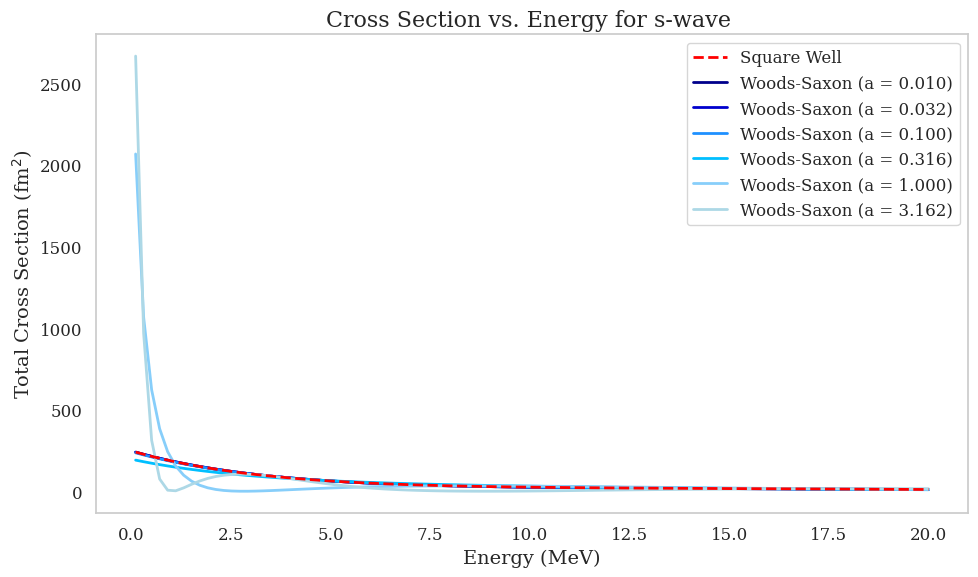

In [41]:
E_values = np.linspace(0.1, 20.0, 100)
a_values = np.logspace(-2, 0.5, 6)  # a approaching 0 logarithmically
l_max = 0

plt.figure(figsize=(10, 6))

shades = ['#00008B', '#0000CD', '#1E90FF', '#00BFFF', '#87CEFA', '#ADD8E6']

# Square Well Potential
cross_sections_sw = calculate_total_cross_sections_numerov(E_values, l_max, a_sw, 'sw', a_sw)
plt.plot(E_values, cross_sections_sw, label="Square Well", color='red', linestyle='--', linewidth=2, zorder=5)

# Woods-Saxon Potentials for each `a` value
for a, shade in zip(a_values, shades):
    cross_sections_ws = calculate_total_cross_sections_numerov(E_values, l_max, R, 'ws', a)
    plt.plot(E_values, cross_sections_ws, label=f"Woods-Saxon (a = {a:.3f})", color=shade, linewidth=2)


plt.xlabel("Energy (MeV)", fontsize=14)
plt.ylabel("Total Cross Section (fm$^2$)", fontsize=14)
plt.title("Cross Section vs. Energy for s-wave ", fontsize=16)
plt.grid(False)
plt.legend(loc="upper right", fontsize=12)
plt.tight_layout()
plt.show()


Plot total cross sections up to l=4

/var/folders/tm/9lkgb9zx49q21mqz50bclnhc0000gn/T/ipykernel_28398/1765485831.py:2: RuntimeWarning: overflow encountered in exp
  return -V0 / (1 + np.exp((r - R_ws) / a))


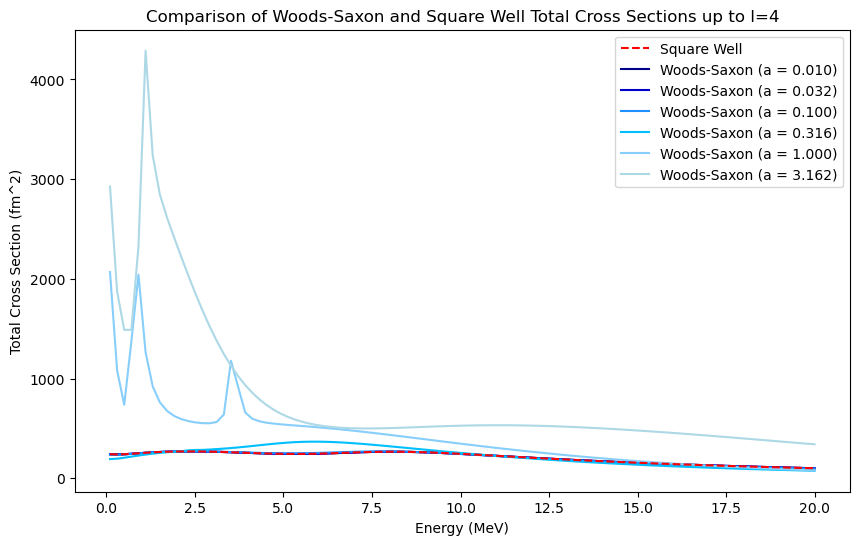

In [25]:
E_values = np.linspace(0.1, 20.0, 100)
a_values = np.logspace(-2, 0.5, 6)
l_max = 4

plt.figure(figsize=(10, 6)) 
shades = ['#00008B', '#0000CD', '#1E90FF', '#00BFFF', '#87CEFA', '#ADD8E6']

# square well potential
cross_sections_sw = calculate_total_cross_sections_numerov(E_values, l_max, a_sw, 'sw', a_sw)
plt.plot(E_values, cross_sections_sw, label="Square Well", color='red', linestyle='--', zorder=5)

# woods-saxon potential
for a, shade in zip(a_values, shades):
    cross_sections_ws = calculate_total_cross_sections_numerov(E_values, l_max, R, 'ws', a)
    plt.plot(E_values, cross_sections_ws, label=f"Woods-Saxon (a = {a:.3f})", color=shade)

plt.xlabel("Energy (MeV)")
plt.ylabel("Total Cross Section (fm^2)")
plt.title(f"Comparison of Woods-Saxon and Square Well Total Cross Sections up to l={l_max}")
plt.legend()
plt.show()

/var/folders/tm/9lkgb9zx49q21mqz50bclnhc0000gn/T/ipykernel_28398/1765485831.py:2: RuntimeWarning: overflow encountered in exp
  return -V0 / (1 + np.exp((r - R_ws) / a))


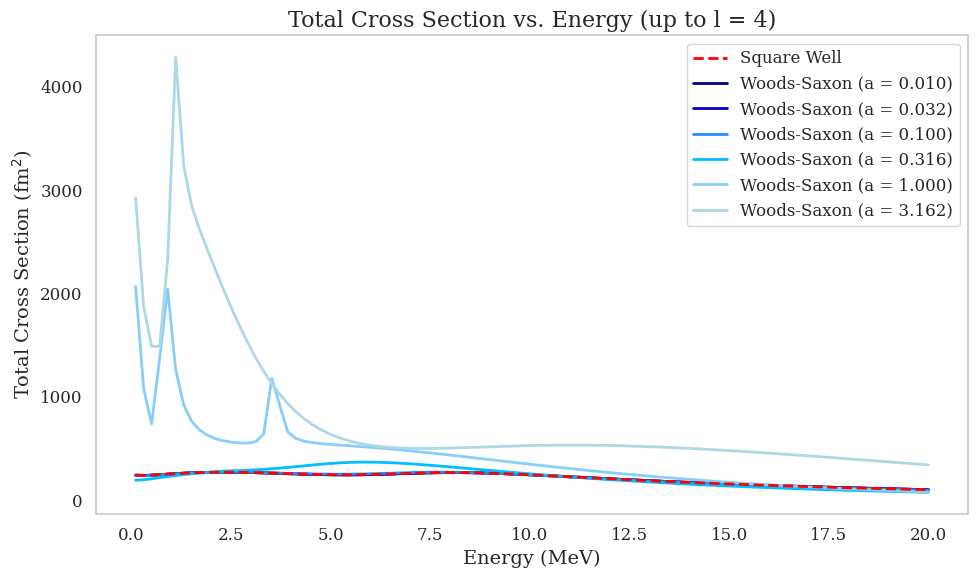

In [42]:
E_values = np.linspace(0.1, 20.0, 100)
a_values = np.logspace(-2, 0.5, 6)  # a approaching 0 logarithmically
l_max = 4

plt.figure(figsize=(10, 6))

shades = ['#00008B', '#0000CD', '#1E90FF', '#00BFFF', '#87CEFA', '#ADD8E6']

# Square Well Potential
cross_sections_sw = calculate_total_cross_sections_numerov(E_values, l_max, a_sw, 'sw', a_sw)
plt.plot(E_values, cross_sections_sw, label="Square Well", color='red', linestyle='--', linewidth=2, zorder=5)

# Woods-Saxon Potentials for each `a` value
for a, shade in zip(a_values, shades):
    cross_sections_ws = calculate_total_cross_sections_numerov(E_values, l_max, R, 'ws', a)
    plt.plot(E_values, cross_sections_ws, label=f"Woods-Saxon (a = {a:.3f})", color=shade, linewidth=2)


plt.xlabel("Energy (MeV)", fontsize=14)
plt.ylabel("Total Cross Section (fm$^2$)", fontsize=14)
plt.title(f"Total Cross Section vs. Energy (up to l = {l_max})")
plt.grid(False)
plt.legend(loc="upper right", fontsize=12)
plt.tight_layout()
plt.show()


As the diffusness parameter (a) of the Woods-Saxon potential appraches 0, the potential becomes steeper and resembles the shape of a square well. This means that the transition from the inner region to the outer region (where the potential is zero) becomes almost instantaneous, as that of a square well. This leads to a smaller total cross section and fewer resonances since the area of interaction is smaller.


A larger diffusness parameter means the transition from attractive potential to zero potential is more gradual. This can be represented by the wavefunction of the neutron interacting with a smooth surface rather than a sharp boundary. Because the transition from attractive potential to zero potential is smooth, the neutron interacts with a larger portion of the nuclear surface. Thus, there are more opportunities for scattering events which leads to a greater total cross section and more resonances.
